<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Time Series: Rolling Statistics


### Learning Objectives

**After this lesson, you will be able to:**
- Define the concepts of trend and seasonality and be able to identify them visually.
- Use boxplots to compare distributions.
- Plot time series data over time to identify large-scale trends in data.
- Investigate trends by computing simple aggregates with Pandas using the `.resample()` function.
- Compute rolling statistics with Pandas to compare data of a date to a smaller window of time.
- Utilize exponentially weighted windows to average out noise.
- Use differences to remove trends in time series data.
- Use the Pandas' `.shift()` function to create lagged features.

---

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Lesson Guide

#### Time Series Rolling Statistics
- [Trend and Seasonality](#A)
- [Aggregate Data](#B)
- [Rolling Statistics](#C)
- [Differencing a Time Series and Stationarity](#D)
- [Shifting and Lagging Time Series Data](#E)
- [Independent Practice](#F)
----

<h2><a id="A">Trend and Seasonality</a></h2>

**Question:** What constitutes a trend in data? Is linearity required for a trend?

- A trend is any long-term change in the value we're measuring. Trends may “change direction,” going from an increasing trend to a decreasing trend.

- Trends can only be measured within the scope of the data collected; there may be trends that are unmeasurable if the data are not complete.

An example of an upward trend:
![trendline](../../assets/trend-line2.png)

- When patterns repeat over *known, fixed periods* of time within a data set, we call this **seasonality**.

- A seasonal pattern exists when a series is influenced by factors related to the cyclic nature of time — i.e., time of month, quarter, year, etc. Seasonality is of a fixed and known period, otherwise it is not truly seasonality. Additionally, it must be either attributed to another factor or counted as a set of anomalous events in the data.

>  Can you think of some seasonal patterns from your own experience?


### The easiest way to visualize trends is by drawing trend lines.

In [2]:
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns

# Import the data.
df = pd.read_csv('../../data/mapquest_google_trends.csv')
df.shape

(640, 2)

In [3]:
# Clean/organize the data. 
df.columns = ['WeekOf', 'Hits']
print(df.head())


       WeekOf  Hits
0  2004-01-04    53
1  2004-01-11    53
2  2004-01-18    54
3  2004-01-25    53
4  2004-02-01    52


In [4]:
df.index

RangeIndex(start=0, stop=640, step=1)

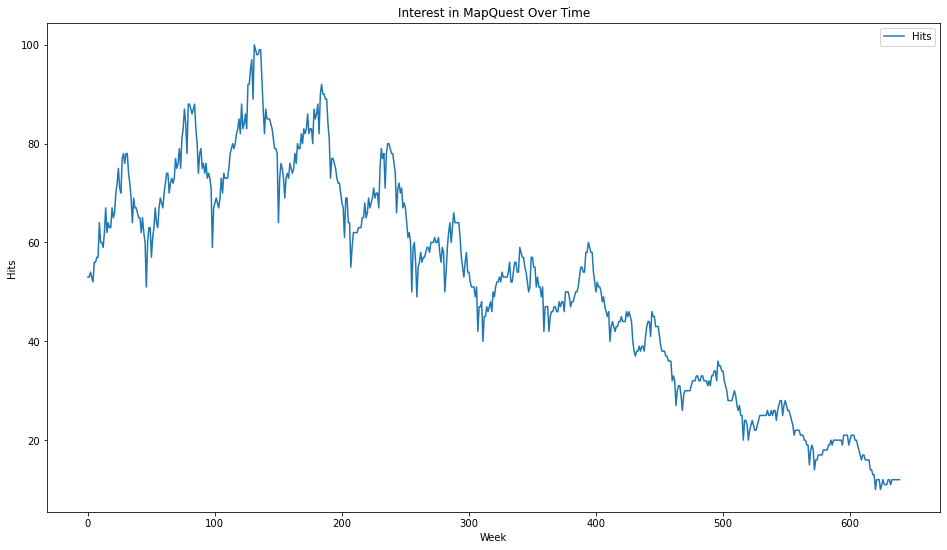

In [5]:
# visualize that trend
plt.rcParams["figure.figsize"] = [16,9]
ax = df.plot(title = "Interest in MapQuest Over Time")
ax.set_xlabel("Week")
ax.set_ylabel("Hits");

Next, we need to compute a coefficient and intercept for our line. NumPy's `polyfit()` method can do this.

Then, define our polynomial function using that coefficient. We can do this on a single dimension using NumPy's `poly1d()` method.

In [7]:
polynomial = np.poly1d(line_coef)
# The intercept is ~86.59, the slope is ~0.11.

# Let's take a look at the trendline values at specific points:
print(polynomial(0))
print(polynomial(100))
print(polynomial(200))

86.58979621684865
75.74840851204469
64.90702080724073


### Now, plot our trendline over the data.

<AxesSubplot:ylabel='Hits'>

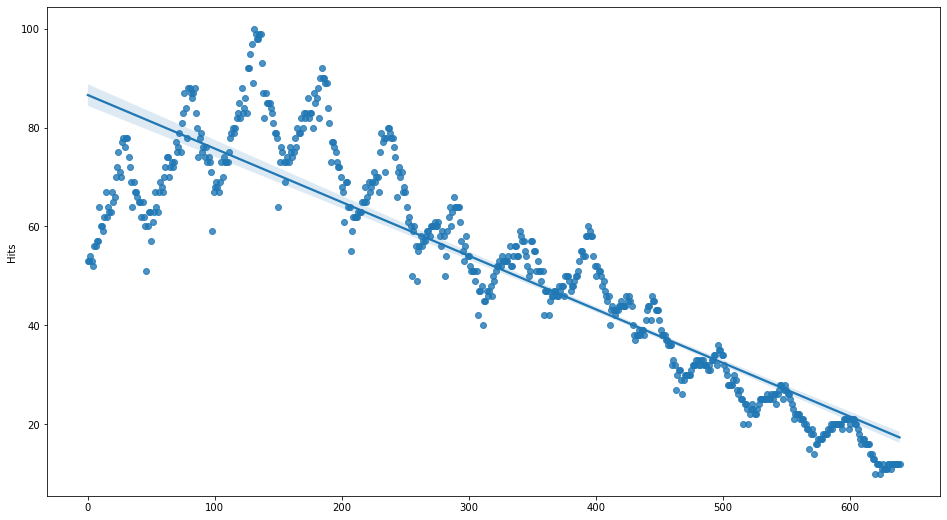

In [8]:
sns.regplot(df.index, df['Hits'])

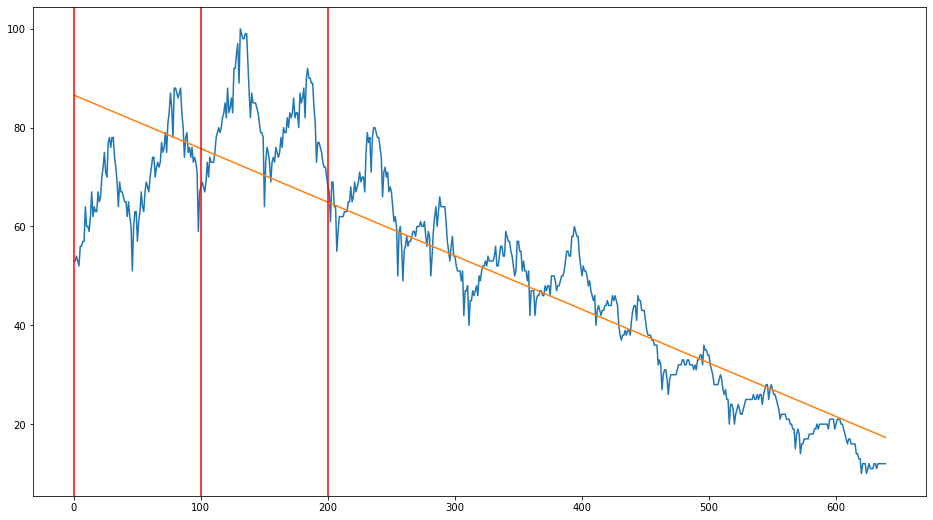

In [9]:
# Plot the time series.
plt.plot(df.index, df['Hits'])

# Plot the least squares minimizing line.
plt.rcParams["figure.figsize"] = [16,9]
plt.plot(df.index, polynomial(df.index))
plt.axvline(x=0, color='red')
plt.axvline(x=100, color='red')
plt.axvline(x=200, color='red');

Looks like a second-order polynomial might fit our data even better. Let's try that out.

In [10]:
line_coef = np.polyfit(df.index,df['Hits'],20)
print(line_coef)

second_polynomial = np.poly1d(line_coef)

[ 1.00367987e-46 -4.68250520e-43  9.20778375e-40 -9.41289380e-37
  4.39097326e-34  6.86801311e-32 -1.97595803e-28  7.41574452e-26
  3.57810908e-23 -5.31491480e-20  2.97299959e-17 -1.03158539e-14
  2.44480143e-12 -4.05622636e-10  4.67970910e-08 -3.63013908e-06
  1.75464044e-04 -4.36533826e-03  1.62524483e-02  1.38132967e+00
  4.93556277e+01]


/Users/champions2019/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


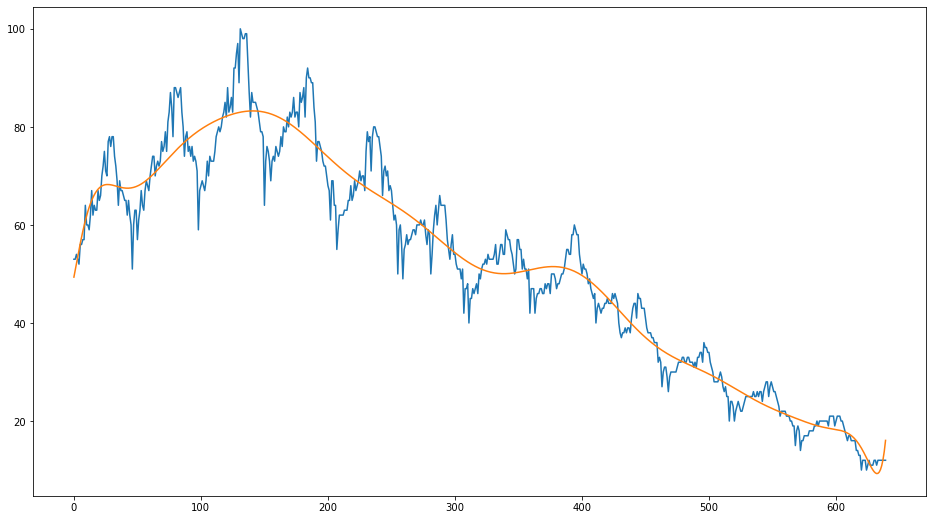

In [11]:
plt.rcParams["figure.figsize"] = [16,9]
# Plot the time series.
plt.plot(df.index, df['Hits'])
# Plot the least squares minimizing line.
plt.plot(df.index, second_polynomial(df.index))

> **Question:** Can you think of any other underlying patterns that might cause trends in time series data? What might cause seasonality in a time series?

### Guided Practice

Let's look for trends and seasonality in data made available by a German drugstore, Rossmann.

These data contain the daily sales made at the drugstore, as well as whether or not a sale or holiday affected the data.

Because we are most interested in the `Date` column (which contains the date of sales for each store), we will make sure to process that as a `datetime` type and make it the index of our DataFrame, as we did with our Apple stock data. 

Let's recall the steps for preprocessing time series data with Pandas:
* Convert time data to a `datetime` object.
* Set `datetime` to index the DataFrame.

In [12]:
# set the figure size
plt.rcParams['figure.figsize'] = (16.0, 8.0)


In [13]:
# read in the data
data = pd.read_csv('../../data/rossmann.csv', skipinitialspace=True, low_memory=False)
data['Date'] = pd.to_datetime(data['Date'])
data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [14]:
data.shape

(1017209, 9)

This allows us to easily filter by date. Let's add a column for `Year` and `Month` based on the `datetime` index. 

In [15]:
data['Year']=data['Date'].dt.year
data[['Date','Year']].head()

,Date,Year
0,2015-07-31,2015
1,2015-07-31,2015
2,2015-07-31,2015
3,2015-07-31,2015
4,2015-07-31,2015


In [16]:
# convert to index
data = data.set_index('Date')

In [17]:
data['Year'] = data.index.year
data['Month'] = data.index.month
data.loc['2015-05'].head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month
Date,,,,,,,,,,
2015-05-31,1,7,0,0,0,0,0,0,2015,5
2015-05-31,2,7,0,0,0,0,0,0,2015,5
2015-05-31,3,7,0,0,0,0,0,0,2015,5
2015-05-31,4,7,0,0,0,0,0,0,2015,5
2015-05-31,5,7,0,0,0,0,0,0,2015,5


In [19]:
data.shape

(1017209, 10)

There are more than a million sales data points in this data set, so, for some simple exploratory data analysis (EDA), we'll focus on just one store.

In [18]:
# create boolean index
is_store1 = data['Store'] == 1

store1_data = data[is_store1]
print(store1_data.shape)
store1_data.head()

(942, 10)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month
Date,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7
2015-07-30,1,4,5020,546,1,1,0,1,2015,7
2015-07-29,1,3,4782,523,1,1,0,1,2015,7
2015-07-28,1,2,5011,560,1,1,0,1,2015,7
2015-07-27,1,1,6102,612,1,1,0,1,2015,7


### Plot the sales data.

Let's investigate whether or not promotions affect sales. For this, we'll use boxplots.

On state holidays, the store is closed (which means there are zero sales), so we need to cut those days out. (Contextual knowledge like this is always necessary to truly explain time series phenomena.)

> **Check for Understanding:** Can you think of any other special considerations we should make when tracking sales?

Now, check to see if there is a difference affecting sales on promotion days.

/Users/champions2019/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


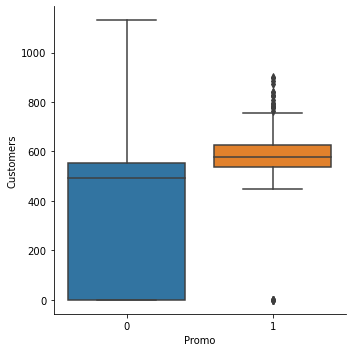

In [20]:
# create a box plot

sns.factorplot(
    x='Promo',
    y='Customers',
    data=store1_data,
    kind='box'
);

/Users/champions2019/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


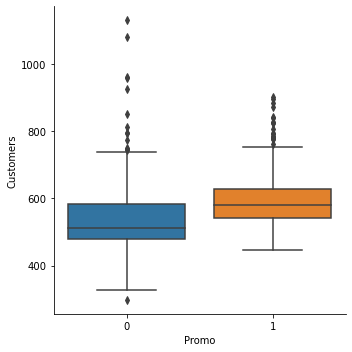

In [21]:
# create a box plot
is_open = store1_data['Open']==1
sns.factorplot(
    x='Promo',
    y='Customers',
    data=store1_data[is_open],
    kind='box'
);

We can see that there _is_ a difference in sales on promotion days.

Why is it important to separate out days on which the store is closed? Because there aren't any promotions on those days either, so including them will bias our sales data on days without promotions! Remember to think about the business logic in addition to analyzing the raw data.

We may also want to compare sales across days of the week:

/Users/champions2019/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


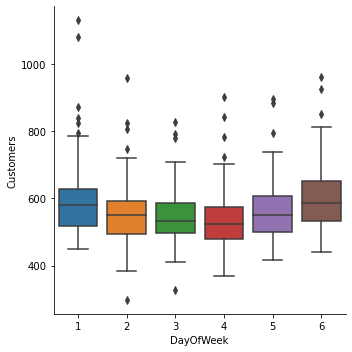

In [22]:
sns.factorplot(
    x='DayOfWeek',
    y='Customers',
    data=store1_data[is_open],
    kind='box',
);

Lastly, we want to identify larger-scale trends in our data. How did sales change from 2014 to 2015? Were there any particularly interesting outliers in terms of sales or customer visits?

To plot the sales and customer visits over time:

<AxesSubplot:xlabel='Date'>

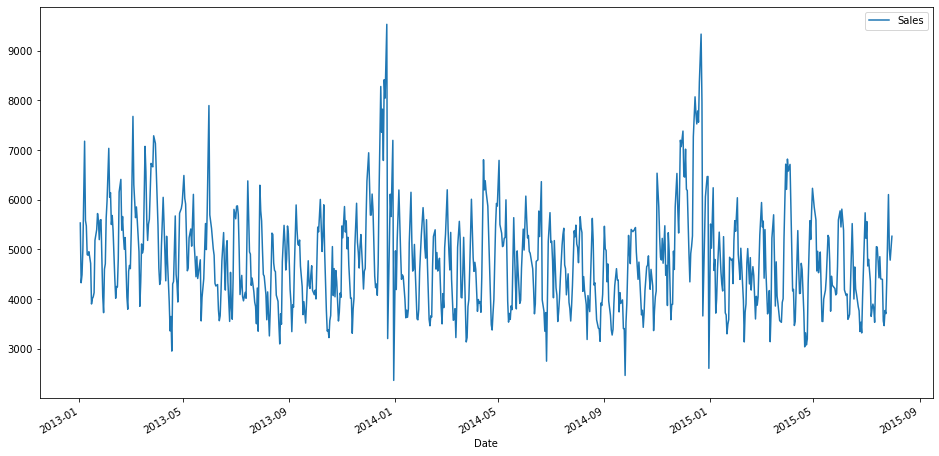

In [23]:
# Filter to days Store 1 was open.

store1_open_data = store1_data[is_open]
store1_open_data[['Sales']].plot()


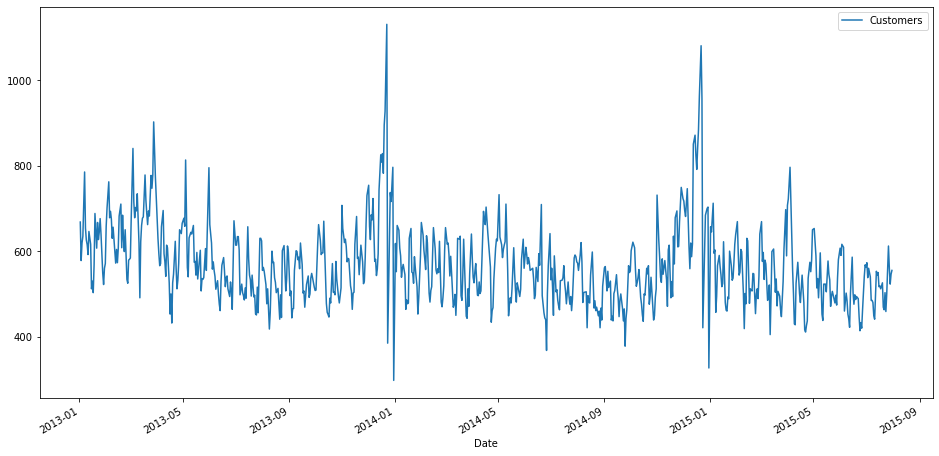

In [24]:
store1_open_data[['Customers']].plot();

We can see that there are large spikes of sales and customers toward the end of 2013 and 2014, leading into the first quarter of 2014 and 2015.

Let's use index filtering to filter just to 2014 changes over time. This should make it easier to identify the holiday sales bump.


            Sales
Date             
2015-01-07   4796
2015-01-06   4574
2015-01-05   6239
2015-01-03   5023
2015-01-02   5509


<AxesSubplot:xlabel='Date'>

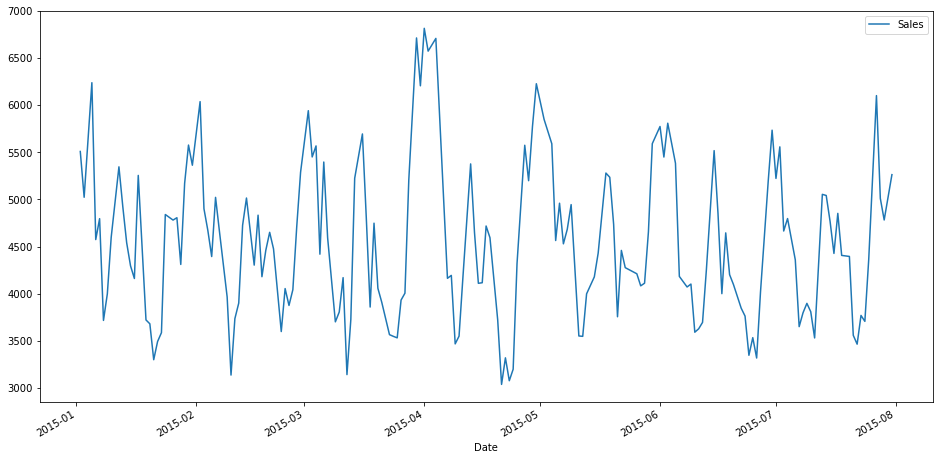

In [25]:
# oops! it looks like our data ends in July.
store1_data_2015 = store1_data.loc['2015']
is_open_2015 = store1_data_2015['Open'] == 1
print(store1_data_2015[is_open_2015][['Sales']].tail())
store1_data_2015[is_open_2015][['Sales']].plot()

<AxesSubplot:xlabel='Date'>

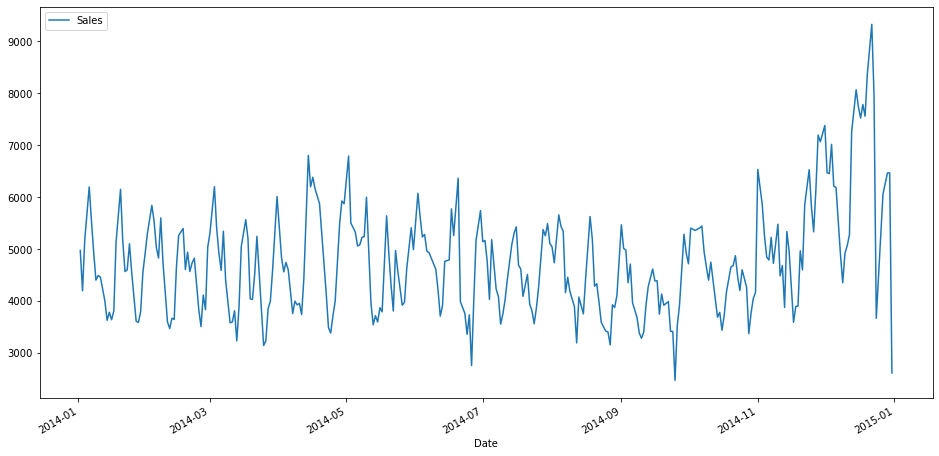

In [26]:
# let's try 2014
store1_data_2014 = store1_data.loc['2014']
is_open_2014 = store1_data_2014['Open'] == 1
store1_data_2014[is_open_2014][['Sales']].plot()

<h2><a id= "B">Aggregate Data</a></h2>
- resample
- rolling

If we want to investigate trends over time in sales, as always, we'll start by computing simple aggregates. We want to know: What were the mean and median sales in each month and year?

We can use `data.resample` on the whole data set and provide:
    - A parameter for the level on which to roll up to: `'D'` for day, `'W'` for week, `'M'` for month, `'A'` for year.
    - The aggregation method to perform: `mean()`, `median()`, `sum()`, etc.
    
pandas documentation: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html

In [27]:
store1_data[['Sales']].head()

,Sales
Date,
2015-07-31,5263
2015-07-30,5020
2015-07-29,4782
2015-07-28,5011
2015-07-27,6102


In [28]:
store1_data.groupby('Year')['Sales'].mean()

Year
2013    4085.315068
2014    3927.145205
2015    3737.292453
Name: Sales, dtype: float64

In [29]:
store1_data['Sales'].resample('A').mean()

Date
2013-12-31    4085.315068
2014-12-31    3927.145205
2015-12-31    3737.292453
Freq: A-DEC, Name: Sales, dtype: float64

In [30]:
# A for annual
print(data[['Sales']].resample('A').mean())
print(store1_data[['Sales']].resample('A').mean())

                  Sales
Date                   
2013-12-31  5658.533675
2014-12-31  5833.290704
2015-12-31  5878.245380
                  Sales
Date                   
2013-12-31  4085.315068
2014-12-31  3927.145205
2015-12-31  3737.292453


In [36]:
# "resample" is exactly like "groupby" only for time-series data. where index => Ts object
data.groupby(['Year'])[['Sales']].mean()

,Sales
Year,
2013,5658.533675
2014,5833.290704
2015,5878.245380


In [34]:
# M for month
data[['Sales']].resample('M').mean().head()

,Sales
Date,
2013-01-31,5211.555578
2013-02-28,5494.371397
2013-03-31,5820.349168
2013-04-30,5483.749836
2013-05-31,5364.127383


In [37]:
# W for week
data[['Sales']].resample('W').mean().head()

,Sales
Date,
2013-01-06,3906.314098
2013-01-13,6313.289174
2013-01-20,4404.582319
2013-01-27,5898.804484
2013-02-03,4928.382960


In [38]:
# Q for quarter
data[['Sales']].resample('Q').mean().head()

,Sales
Date,
2013-03-31,5509.241258
2013-06-30,5416.102558
2013-09-30,5702.286723
2013-12-31,6000.622100
2014-03-31,5577.452098


**Exercise** It looks like average sales were highest in 2015. Now, let's look at the median annual sales.

In [39]:
data[['Sales']].resample('A').median().head()

,Sales
Date,
2013-12-31,5598.0
2014-12-31,5794.0
2015-12-31,5916.0


<AxesSubplot:xlabel='Date'>

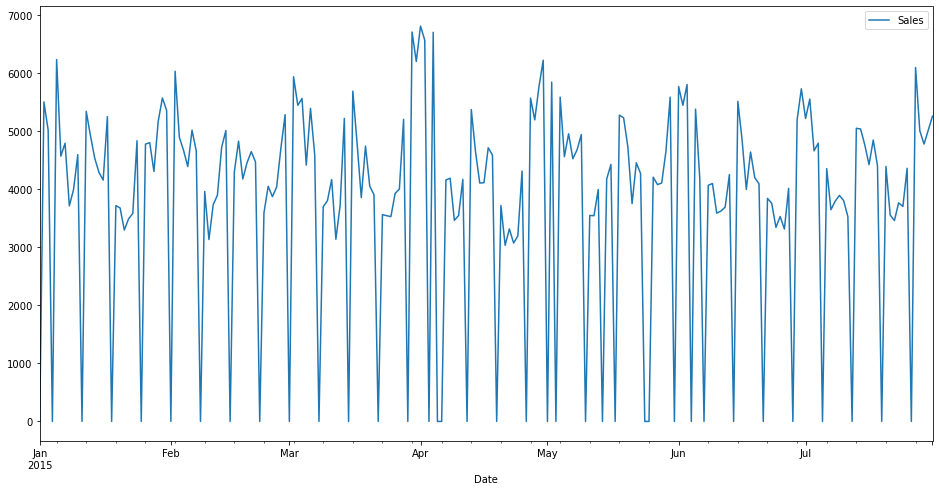

In [40]:
store1_data[store1_data['Year']==2015][['Sales']].plot()

<AxesSubplot:xlabel='Date'>

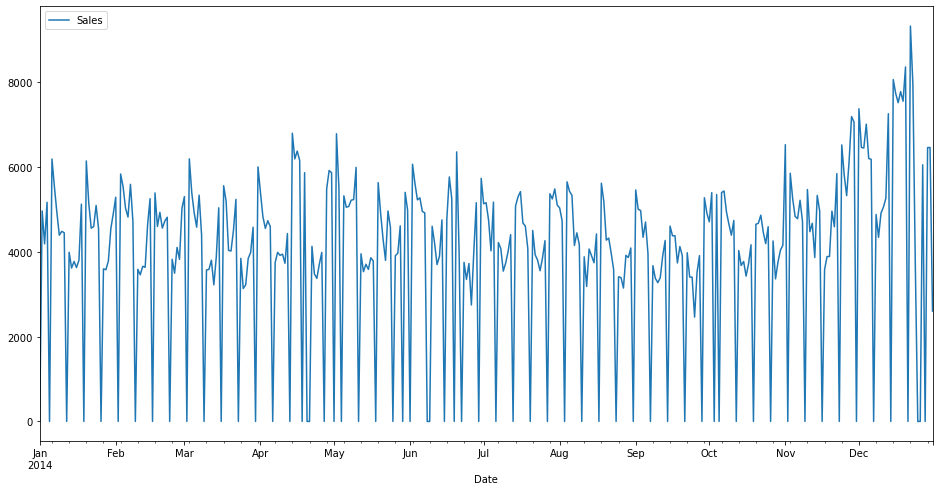

In [45]:
# plot quarterly data
store1_data[store1_data['Year']==2014][['Sales']].resample('D').mean().plot()

For more information, see Pandas' `.resample`  [documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html).

> **Question:** How do aggregation techniques help us sort out important insights from the noise of time series data?

<h2><a id = "C">Rolling Statistics</a><h2>

With time series, we can "roll" statistics across time. For example, the rolling mean is the mean of a moving window across time periods. Pandas offers a variety of functionalities for creating rolling statistics, which we'll only scratch the surface of here.

E.g., to understand holidays sales, we don't want to compare sales data in late December with the entire month but instead with a few days immediately surrounding it. We can do this using rolling averages.

The syntax for these can be a little tricky at first. We'll be using a `rolling()` function with a statistical function chained to it. Let's dive into more detail.

### Parameters for `rolling()` Functions

`rolling().mean()` (as well as `rolling().median())` can take the following parameters:

* The first indicates the time series to aggregate.
* `window` indicates the number of periods to include in the average.
* `center` indicates whether the window should be centered on the date or use data prior to that date.


#### Calculate the rolling daily sum over all stores.

Use the `.resample()` function to calculate the daily total over all of the stores.

In [46]:
data[['Sales']].sum()

Sales    5873180623
dtype: int64

In [47]:
# without "resample"
data.groupby('Year')['Sales'].sum()

Year
2013    2302876084
2014    2180804896
2015    1389499643
Name: Sales, dtype: int64

In [48]:
# same
data[['Sales']].resample('a').sum()

,Sales
Date,
2013-12-31,2302876084
2014-12-31,2180804896
2015-12-31,1389499643


In [49]:
# resample the sales data into daily totals
daily_store_sales = data[['Sales']].resample('D').sum()
daily_store_sales.tail()

,Sales
Date,
2015-07-27,10707292
2015-07-28,9115073
2015-07-29,8499962
2015-07-30,8798854
2015-07-31,10109742


In [53]:
daily_store_sales.tail(3).values

array([[ 8499962],
       [ 8798854],
       [10109742]])

In [52]:
daily_store_sales.tail(3).values.sum()

27408558

In [54]:
daily_store_sales.tail(3).values.sum()/3

9136186.0

Use the `.rolling()` function to calculate the rolling average over a three-day period.

In [55]:
# suppress scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

In [62]:
daily_store_sales.head(5)

,Sales
Date,
2013-01-01,97235
2013-01-02,6949829
2013-01-03,6347820
2013-01-04,6638954
2013-01-05,5951593


In [61]:
daily_store_sales.rolling(window = 3).mean().head(10)

,Sales
Date,
2013-01-01,NaN
2013-01-02,NaN
2013-01-03,4464961.33
2013-01-04,6645534.33
2013-01-05,6312789.00
2013-01-06,4244817.00
2013-01-07,5640781.67
2013-01-08,6573396.33
2013-01-09,9107629.33


In [64]:
# create 3-day rolling average 
daily_store_sales.rolling(window=3, center=True).mean().head()

,Sales
Date,
2013-01-01,NaN
2013-01-02,4464961.33
2013-01-03,6645534.33
2013-01-04,6312789.00
2013-01-05,4244817.00


/var/folders/6z/smv4kfs12fv5tpcrw97pcfd40000gn/T/ipykernel_13309/3735989241.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  daily_store_sales[is_open].plot()


<AxesSubplot:xlabel='Date'>

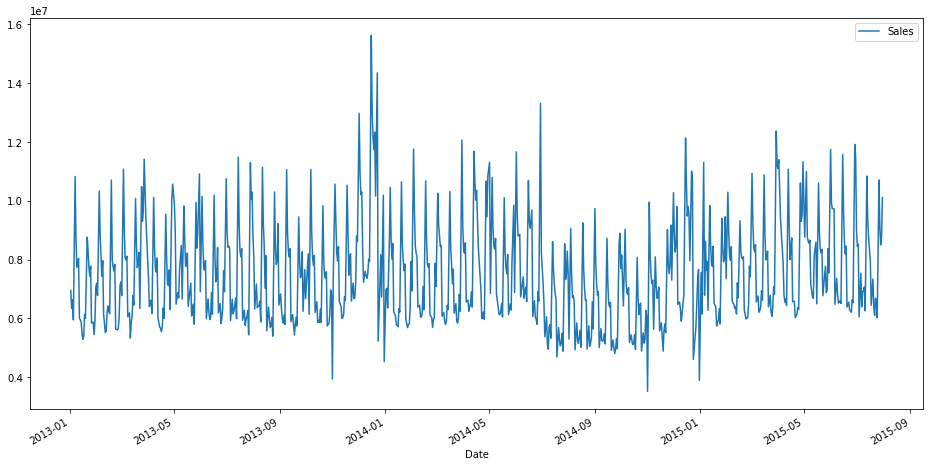

In [65]:
daily_store_sales[is_open].plot()

/var/folders/6z/smv4kfs12fv5tpcrw97pcfd40000gn/T/ipykernel_13309/2178917723.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  daily_store_sales[is_open].rolling(window=365, center=False).mean().plot();


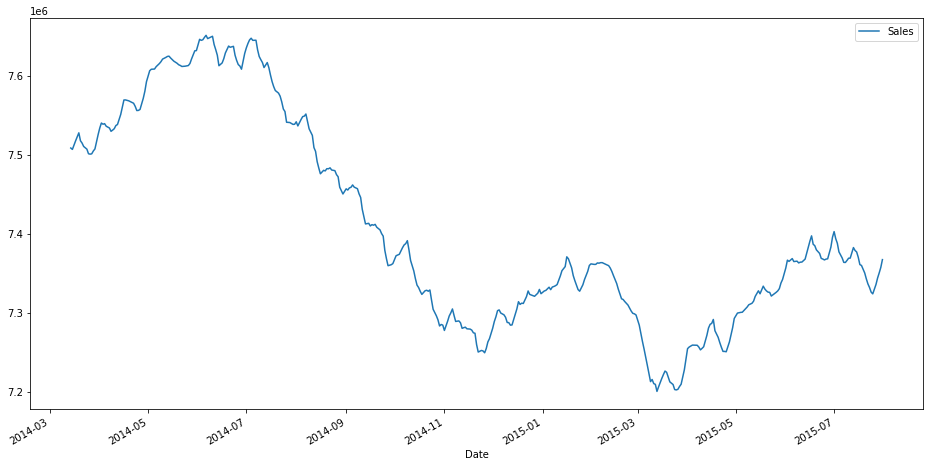

In [66]:
daily_store_sales[is_open].rolling(window=365, center=False).mean().plot();

**Why is there an `NaN` in the first entry?**

We can use our index filtering to just look at 2015.

In [70]:
daily_store_sales['2015'].head(10)

,Sales
Date,
2015-01-01,130162
2015-01-02,7561431
2015-01-03,6150311
2015-01-04,197193
2015-01-05,11303805
2015-01-06,6791481
2015-01-07,8621857
2015-01-08,7646645
2015-01-09,7945387


In [67]:
# look at the 7-day rolling mean for 2015
daily_store_sales.rolling( window=7, center=True).mean()['2015'].head()

,Sales
Date,
2015-01-01,4698836.71
2015-01-02,5272033.71
2015-01-03,5147139.14
2015-01-04,5822320.00
2015-01-05,6896103.29


Instead of plotting the full time series, we can plot the rolling mean instead, which smooths random changes in sales and removes outliers, helping us identify larger trends.

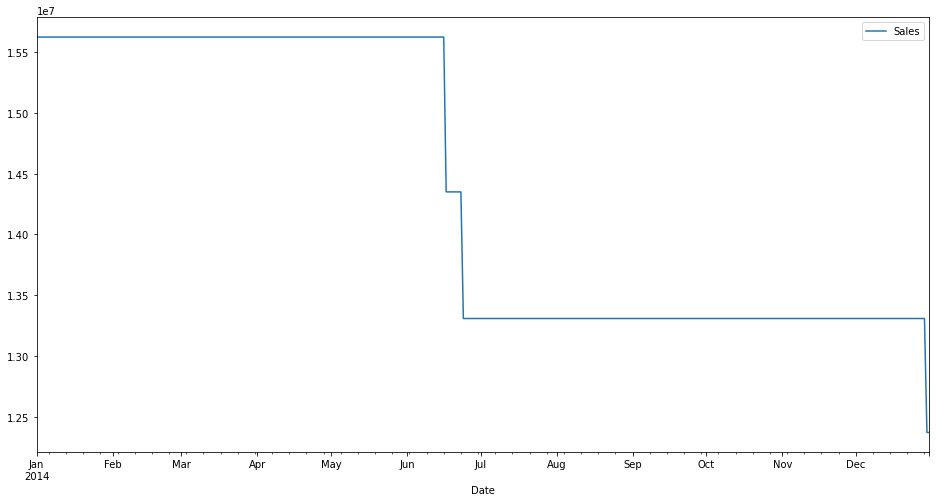

In [76]:
daily_store_sales.rolling(window=365, center=True).max()['2014'].plot();

### The Expanding Mean

The expanding mean simply uses all of the data points up to the current time to calculate the mean, as opposed to a moving window.

#### Calculate and plot the expanding mean below. Resample by quarter.

In [77]:
quarterly = data['Sales'].resample('Q').sum()
quarterly

Date
2013-03-31    552846851
2013-06-30    549544846
2013-09-30    584940572
2013-12-31    615543815
2014-03-31    559697318
2014-06-30    579285285
2014-09-30    502157350
2014-12-31    539664943
2015-03-31    582750871
2015-06-30    594426156
2015-09-30    212322616
Freq: Q-DEC, Name: Sales, dtype: int64

In [80]:
quarterly.head(2).values.sum()/2

551195848.5

In [81]:
quarterly.rolling(window=1, center=False).mean()

Date
2013-03-31   552846851.00
2013-06-30   549544846.00
2013-09-30   584940572.00
2013-12-31   615543815.00
2014-03-31   559697318.00
2014-06-30   579285285.00
2014-09-30   502157350.00
2014-12-31   539664943.00
2015-03-31   582750871.00
2015-06-30   594426156.00
2015-09-30   212322616.00
Freq: Q-DEC, Name: Sales, dtype: float64

In [82]:
data.Sales.resample('Q').sum().head()

Date
2013-03-31    552846851
2013-06-30    549544846
2013-09-30    584940572
2013-12-31    615543815
2014-03-31    559697318
Freq: Q-DEC, Name: Sales, dtype: int64

In [83]:
# quarterly rolling mean
rolling_mean = data.Sales.resample('Q').sum().rolling(window=3, center=False).mean().head()
rolling_mean

Date
2013-03-31            NaN
2013-06-30            NaN
2013-09-30   562444089.67
2013-12-31   583343077.67
2014-03-31   586727235.00
Freq: Q-DEC, Name: Sales, dtype: float64

In [84]:
expanding_mean = data.Sales.resample('Q').sum().expanding().mean().head()
expanding_mean

Date
2013-03-31   552846851.00
2013-06-30   551195848.50
2013-09-30   562444089.67
2013-12-31   575719021.00
2014-03-31   572514680.40
Freq: Q-DEC, Name: Sales, dtype: float64

In [ ]:
print(rolling_mean, expanding_mean)

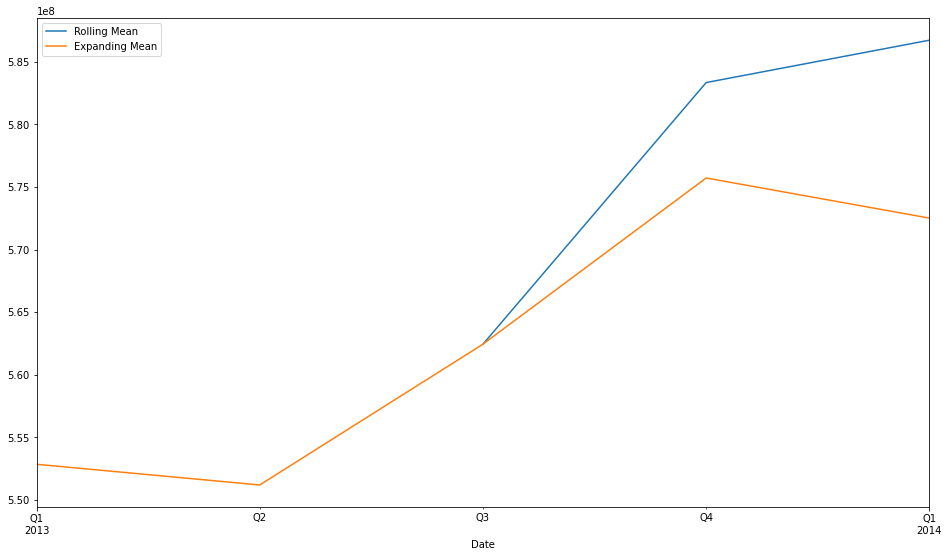

In [85]:
plt.rcParams["figure.figsize"] = [16,9]
fig, ax = plt.subplots()
rolling_mean.plot(legend = True)
expanding_mean.plot(legend = True)
ax.legend(['Rolling Mean', 'Expanding Mean']);

### Exponentially Weighted Windows

Exponentially weighted windows are one of the most common and effective ways of averaging out noise in time series data. The averaging is done with an "exponential decay" on the contribution of prior means, decreasing the contribution of time points that are further in the past.

The (adjusted) exponentially weighted mean for time, $t$, is defined as:

<a id="-xt--fracxt-----alphaxt------alphaxt--------alphatx------alpha-----alpha-------alphat-"></a>
### $$ x_t = \frac{x_t + (1 - \alpha)x_{t-1} + (1 - \alpha)^2x_{t-1} + ... + (1 - \alpha)^{t}x_0} {1 + (1 - \alpha) + (1 - \alpha)^2 + ... + (1 - \alpha)^{t}} $$

> **Note:** Review Pandas' [documentation](http://pandas.pydata.org/pandas-docs/stable/computation.html#exponentially-weighted-windows) for more information.

**Calculate and plot the exponentially weighted sum along with the rolling sum. What's the difference?**

For example: `.resample('Q').sum().ewm(span=10).mean()`.


In [86]:
rolling_mean = data.Sales.resample('Q').sum().rolling(window=3, center=False).mean()

In [87]:
rolling_mean

Date
2013-03-31            NaN
2013-06-30            NaN
2013-09-30   562444089.67
2013-12-31   583343077.67
2014-03-31   586727235.00
2014-06-30   584842139.33
2014-09-30   547046651.00
2014-12-31   540369192.67
2015-03-31   541524388.00
2015-06-30   572280656.67
2015-09-30   463166547.67
Freq: Q-DEC, Name: Sales, dtype: float64

In [88]:
exp_weighted_mean = data.Sales.resample('Q').sum().ewm(span=10).mean()
exp_weighted_mean

Date
2013-03-31   552846851.00
2013-06-30   551030748.25
2013-09-30   564662272.08
2013-12-31   581425473.47
2014-03-31   575187910.99
2014-06-30   576252140.55
2014-09-30   558398272.49
2014-12-31   554136349.75
2015-03-31   560361868.23
2015-06-30   567517281.88
2015-09-30   494955452.26
Freq: Q-DEC, Name: Sales, dtype: float64

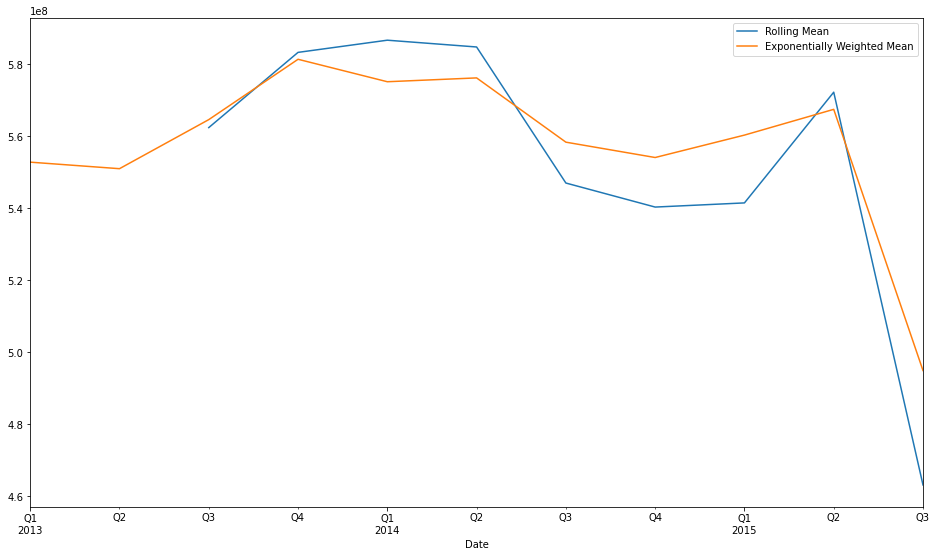

In [89]:
plt.rcParams["figure.figsize"] = [16,9]
fig, ax = plt.subplots()
rolling_mean.plot(legend = True)
exp_weighted_mean.plot(legend = True)
ax.legend(['Rolling Mean', 'Exponentially Weighted Mean'])

*Note that rolling doesn't understand if you are missing periods (e.g., if you roll over three days and your data are missing weekends, it'll roll Fri/Sat/Sun), so you need to resample first if you care about that.*

> **Question:** How does the signal that's captured by rolling statistics differ from the signal captured by resampling time series data?

<h2><a id = "D">Differencing a Time Series and Stationarity</a></h2>

If a time series is stationary, the mean, variance, and autocorrelation (covered in the next section) will be constant over time. Forecasting methods typically assume the time series you are forecasting on to be stationary — or at least approximately stationary.

The most common way to make a time series stationary is through "differencing." This procedure converts a time series into the difference between values.

<a id="-delta-yt--yt---yt--"></a>
### $$ \Delta y_t = y_t - y_{t-1} $$

This removes trends in the time series and ensures that the mean across time is zero. In most cases, this only requires a single difference, although, in some, a second difference (or third, etc.) will be necessary to remove trends.

In [93]:
store1_data[['Sales']].head(10)

,Sales
Date,
2015-07-31,5263
2015-07-30,5020
2015-07-29,4782
2015-07-28,5011
2015-07-27,6102
2015-07-26,0
2015-07-25,4364
2015-07-24,3706
2015-07-23,3769


In [94]:
store1_data['7day_diff'] = store1_data['Sales'].diff(periods = 7)
store1_data[['Sales','7day_diff']].head(10)

/var/folders/6z/smv4kfs12fv5tpcrw97pcfd40000gn/T/ipykernel_13309/912947383.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  store1_data['7day_diff'] = store1_data['Sales'].diff(periods = 7)


,Sales,7day_diff
Date,,
2015-07-31,5263,NaN
2015-07-30,5020,NaN
2015-07-29,4782,NaN
2015-07-28,5011,NaN
2015-07-27,6102,NaN
2015-07-26,0,NaN
2015-07-25,4364,NaN
2015-07-24,3706,-1557.00
2015-07-23,3769,-1251.00


In [95]:
store1_data['2day_diff'] = store1_data['Sales'].diff(periods = 2)
store1_data[['Sales','7day_diff', '2day_diff']].head(10)

/var/folders/6z/smv4kfs12fv5tpcrw97pcfd40000gn/T/ipykernel_13309/1966263351.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  store1_data['2day_diff'] = store1_data['Sales'].diff(periods = 2)


,Sales,7day_diff,2day_diff
Date,,,
2015-07-31,5263,NaN,NaN
2015-07-30,5020,NaN,NaN
2015-07-29,4782,NaN,-481.00
2015-07-28,5011,NaN,-9.00
2015-07-27,6102,NaN,1320.00
2015-07-26,0,NaN,-5011.00
2015-07-25,4364,NaN,-1738.00
2015-07-24,3706,-1557.00,3706.00
2015-07-23,3769,-1251.00,-595.00


In [96]:
store1_data=store1_data.sort_index()
store1_data

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,7day_diff,2day_diff
Date,,,,,,,,,,,,
2013-01-01,1,2,0,0,0,0,a,1,2013,1,-5580.00,-4327.00
2013-01-02,1,3,5530,668,1,0,0,1,2013,1,59.00,1044.00
2013-01-03,1,4,4327,578,1,0,0,1,2013,1,-565.00,-670.00
2013-01-04,1,5,4486,619,1,0,0,1,2013,1,-395.00,4486.00
2013-01-05,1,6,4997,635,1,0,0,1,2013,1,45.00,-2179.00
...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-27,1,1,6102,612,1,1,0,1,2015,7,NaN,1320.00
2015-07-28,1,2,5011,560,1,1,0,1,2015,7,NaN,-9.00
2015-07-29,1,3,4782,523,1,1,0,1,2015,7,NaN,-481.00


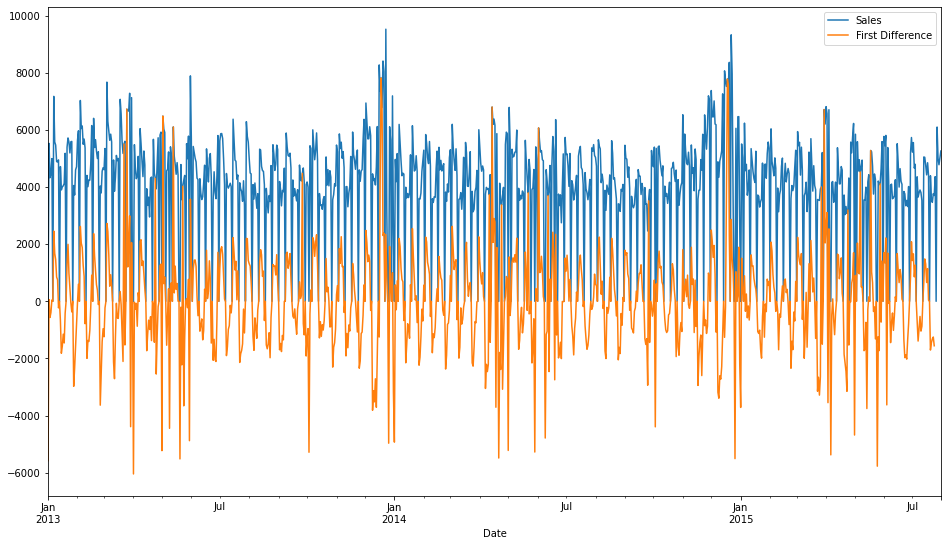

In [97]:
plt.rcParams["figure.figsize"] = [16,9]
fig, ax = plt.subplots()
store1_data['Sales'].plot(legend = True)
store1_data['7day_diff'].plot(legend = True)
ax.legend(['Sales', 'First Difference']);

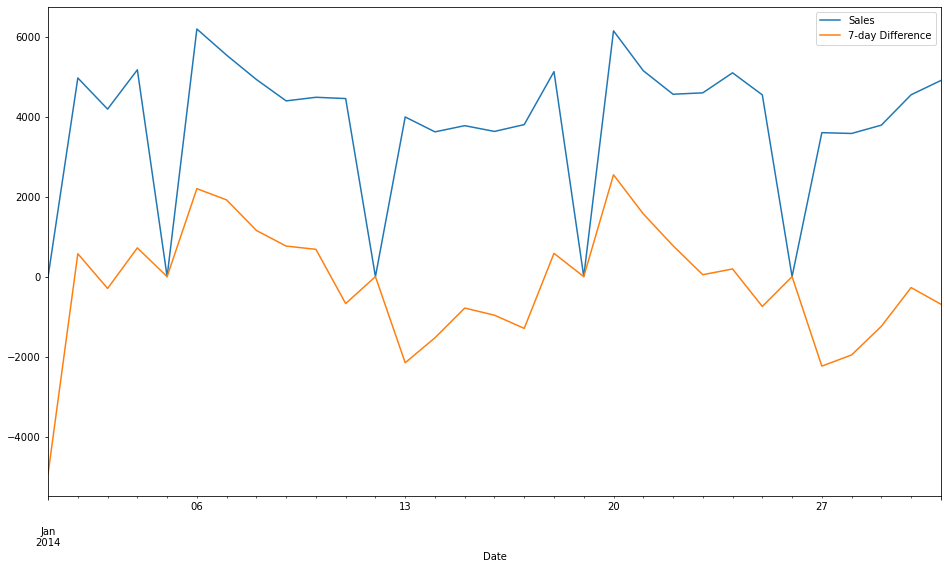

In [99]:
plt.rcParams["figure.figsize"] = [16,9]
fig, ax = plt.subplots()
store1_data['2014-01']['Sales'].plot(legend = True)
store1_data['2014-01']['7day_diff'].plot(legend = True)
ax.legend(['Sales', '7-day Difference']);

> **Check:** How does differencing help with problems of non-stationarity and autocorrelation in time series data?

<h2><a id="E">Shifting and Lagging Time Series Data</a></h2>

Another common operation on time series data is shifting or lagging values backward and forward in time. This can help us calculate the percentage of change from sample to sample. Pandas has a `.shift()` method for shifting the data in a DataFrame.

Let's take a look at the Rossman data when we apply lagged features. 

In [100]:
store1_data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,7day_diff,2day_diff
Date,,,,,,,,,,,,
2013-01-01,1,2,0,0,0,0,a,1,2013,1,-5580.00,-4327.00
2013-01-02,1,3,5530,668,1,0,0,1,2013,1,59.00,1044.00
2013-01-03,1,4,4327,578,1,0,0,1,2013,1,-565.00,-670.00
2013-01-04,1,5,4486,619,1,0,0,1,2013,1,-395.00,4486.00
2013-01-05,1,6,4997,635,1,0,0,1,2013,1,45.00,-2179.00


Let's shift the sales price by one day.

In [101]:
# shift data ahead by one day
shifted_forward = store1_data.shift(1)
shifted_forward.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,7day_diff,2day_diff
Date,,,,,,,,,,,,
2013-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,1.00,2.00,0.00,0.00,0.00,0.00,a,1.00,2013.00,1.00,-5580.00,-4327.00
2013-01-03,1.00,3.00,5530.00,668.00,1.00,0.00,0,1.00,2013.00,1.00,59.00,1044.00
2013-01-04,1.00,4.00,4327.00,578.00,1.00,0.00,0,1.00,2013.00,1.00,-565.00,-670.00
2013-01-05,1.00,5.00,4486.00,619.00,1.00,0.00,0,1.00,2013.00,1.00,-395.00,4486.00


In [102]:
# makes more sense to do just one column
store1_data['shifted_sales'] = store1_data['Sales'].shift(3)
store1_data[['shifted_sales', 'Sales'] ].head(10)

,shifted_sales,Sales
Date,,
2013-01-01,NaN,0
2013-01-02,NaN,5530
2013-01-03,NaN,4327
2013-01-04,0.00,4486
2013-01-05,5530.00,4997
2013-01-06,4327.00,0
2013-01-07,4486.00,7176
2013-01-08,4997.00,5580
2013-01-09,0.00,5471


In [103]:
store1_data['daily_diff'] = store1_data['shifted_sales']- store1_data['Sales'] 
store1_data[['shifted_sales', 'Sales','daily_diff']].head()

,shifted_sales,Sales,daily_diff
Date,,,
2013-01-01,NaN,0,NaN
2013-01-02,NaN,5530,NaN
2013-01-03,NaN,4327,NaN
2013-01-04,0.00,4486,-4486.00
2013-01-05,5530.00,4997,533.00


In [104]:
store1_data['daily_diff2']=store1_data['Sales'].diff(3)
store1_data[['shifted_sales', 'Sales','daily_diff','daily_diff2']].head()

,shifted_sales,Sales,daily_diff,daily_diff2
Date,,,,
2013-01-01,NaN,0,NaN,NaN
2013-01-02,NaN,5530,NaN,NaN
2013-01-03,NaN,4327,NaN,NaN
2013-01-04,0.00,4486,-4486.00,4486.00
2013-01-05,5530.00,4997,533.00,-533.00


*Notice that the first row now contains NaN values because there wasn't a previous day's data to shift to that day.*

Next, let's shift the sales prices by five days.

In [105]:
shifted_forward5 = store1_data.shift(5)
shifted_forward5.head(10)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,7day_diff,2day_diff,shifted_sales,daily_diff,daily_diff2
Date,,,,,,,,,,,,,,,
2013-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-06,1.00,2.00,0.00,0.00,0.00,0.00,a,1.00,2013.00,1.00,-5580.00,-4327.00,NaN,NaN,NaN
2013-01-07,1.00,3.00,5530.00,668.00,1.00,0.00,0,1.00,2013.00,1.00,59.00,1044.00,NaN,NaN,NaN
2013-01-08,1.00,4.00,4327.00,578.00,1.00,0.00,0,1.00,2013.00,1.00,-565.00,-670.00,NaN,NaN,NaN
2013-01-09,1.00,5.00,4486.00,619.00,1.00,0.00,0,1.00,2013.00,1.00,-395.00,4486.00,0.00,-4486.00,4486.00


We can also use negative numbers to shift the sales values in the reverse direction.

In [106]:
shifted_backward = store1_data.shift(-1)
shifted_backward.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,7day_diff,2day_diff,shifted_sales,daily_diff,daily_diff2
Date,,,,,,,,,,,,,,,
2013-01-01,1.00,3.00,5530.00,668.00,1.00,0.00,0,1.00,2013.00,1.00,59.00,1044.00,NaN,NaN,NaN
2013-01-02,1.00,4.00,4327.00,578.00,1.00,0.00,0,1.00,2013.00,1.00,-565.00,-670.00,NaN,NaN,NaN
2013-01-03,1.00,5.00,4486.00,619.00,1.00,0.00,0,1.00,2013.00,1.00,-395.00,4486.00,0.00,-4486.00,4486.00
2013-01-04,1.00,6.00,4997.00,635.00,1.00,0.00,0,1.00,2013.00,1.00,45.00,-2179.00,5530.00,533.00,-533.00
2013-01-05,1.00,7.00,0.00,0.00,0.00,0.00,0,1.00,2013.00,1.00,0.00,-5580.00,4327.00,4327.00,-4327.00


Lags can be used to calculate the changes in the values you are tracking with your time series data. In this case, we can use Pandas' `.shift()` method to look at the changes in sales. 

Let's create a new column in our Rossman DataFrame that contains the previous day's sales. 

*Note that we add `.copy()` to the end of the chained assignment to explicitly tell Pandas that this will be a copy and not a view. Here is a useful [video](https://www.youtube.com/watch?v=4R4WsDJ-KVc) that helps explain how to avoid SettingCopyWithWarning errors in Pandas.*

In [107]:
# use shift to create a new column
store1_data['Prev Day Sales'] = store1_data['Sales'].shift(1).copy()
store1_data[['Sales','Prev Day Sales'] ].head()

,Sales,Prev Day Sales
Date,,
2013-01-01,0,NaN
2013-01-02,5530,0.00
2013-01-03,4327,5530.00
2013-01-04,4486,4327.00
2013-01-05,4997,4486.00


Using our new column, it's simple to calculate the one-day change in sales at Store 1. Let's create a new column for this value in our DataFrame as well.

In [108]:
store1_data['Sales Change'] = store1_data['Sales'] - store1_data['Prev Day Sales'].copy()
store1_data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,7day_diff,2day_diff,shifted_sales,daily_diff,daily_diff2,Prev Day Sales,Sales Change
Date,,,,,,,,,,,,,,,,,
2013-01-01,1,2,0,0,0,0,a,1,2013,1,-5580.00,-4327.00,NaN,NaN,NaN,NaN,NaN
2013-01-02,1,3,5530,668,1,0,0,1,2013,1,59.00,1044.00,NaN,NaN,NaN,0.00,5530.00
2013-01-03,1,4,4327,578,1,0,0,1,2013,1,-565.00,-670.00,NaN,NaN,NaN,5530.00,-1203.00
2013-01-04,1,5,4486,619,1,0,0,1,2013,1,-395.00,4486.00,0.00,-4486.00,4486.00,4327.00,159.00
2013-01-05,1,6,4997,635,1,0,0,1,2013,1,45.00,-2179.00,5530.00,533.00,-533.00,4486.00,511.00


> **Question:** What are some other real-world applications you can think of for shifting data in a time series?

# Recap

* Trends are long-term changes in data. We have to sort through the noise of a time series to identify trends.
* We can resample the data to look at simple aggregates and identify patterns.
* Rolling statistics give us a local statistic of an average in time, smoothing out random fluctuations and removing outliers.

<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Time Series: Rolling Statistics


# Independent Practice

**Instructor Note:** These are optional and can be assigned as student practice questions outside of class.

### 1) Load the Unemployment data set. Perform any necessary cleaning and preprocess the data by creating a `datetime` index.

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime


In [110]:
unemp = pd.read_csv('../../data/unemployment.csv')
unemp.head()

,Quarter,Seasonally adjusted quarterly U.S. unemployment rates from 1948 to 1993
0,1948Q1,3.733%
1,1948Q2,3.667%
2,1948Q3,3.767%
3,1948Q4,3.833%
4,1949Q1,4.667%


In [111]:
unemp.tail()

,Quarter,Seasonally adjusted quarterly U.S. unemployment rates from 1948 to 1993
170,1990Q3,5.6%
171,1990Q4,5.9%
172,1991Q1,6.5%
173,1991Q2,6.833%
174,Seasonally adjusted quarterly U.S. unemploymen...,NaN


In [112]:
print(unemp.shape)
unemp = unemp.drop(174, axis=0)
print(unemp.shape)

(175, 2)
(174, 2)


In [113]:
# data cleaning
unemp.columns = ['year_quarter', 'unemployment_rate']
unemp['unemployment_rate'] = unemp['unemployment_rate'].map(lambda x: float(str(x).replace('%','')))
unemp.dropna(inplace=True)

In [114]:
unemp.head()

,year_quarter,unemployment_rate
0,1948Q1,3.73
1,1948Q2,3.67
2,1948Q3,3.77
3,1948Q4,3.83
4,1949Q1,4.67


In [115]:
unemp.dtypes

year_quarter          object
unemployment_rate    float64
dtype: object

In [116]:
# This is quarterly data, so converting to datetime is a bit complicated. .dt.to_period('Q') will help us represent the string as a datetime object.
unemp['date'] = pd.to_datetime(unemp.year_quarter).dt.to_period('Q')
unemp.set_index('date', inplace=True)
unemp.sort_index()
unemp.head()

,year_quarter,unemployment_rate
date,,
1948Q1,1948Q1,3.73
1948Q2,1948Q2,3.67
1948Q3,1948Q3,3.77
1948Q4,1948Q4,3.83
1949Q1,1949Q1,4.67


In [117]:
print(unemp.shape)
unemp = unemp.drop('year_quarter', axis=1)
print(unemp.shape)

(174, 2)
(174, 1)


### 2) Plot the unemployment rate.

<AxesSubplot:xlabel='date'>

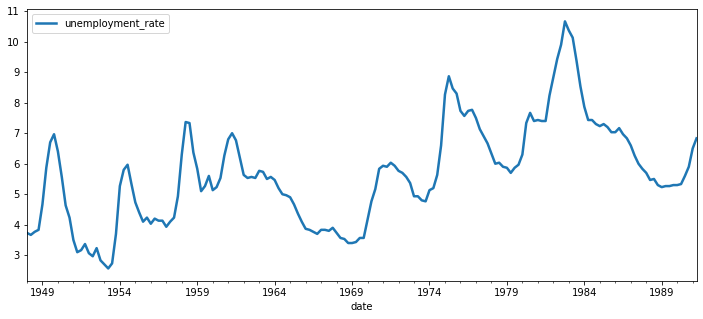

In [118]:
unemp.plot(lw=2.5, figsize=(12,5))

### 3) Calculate the rolling mean of years with `window=3 `, without centering, and plot both the unemployment rates and the rolling mean data.

In [119]:
yearly = unemp['unemployment_rate'].resample('A').mean().rolling(window=3, center=False).mean()
yearly.head()

date
1948    NaN
1949    NaN
1950   5.00
1951   4.85
1952   3.84
Freq: A-DEC, Name: unemployment_rate, dtype: float64

In [120]:
# Extract the dates from the index as timestamps.
date_ticks_orig = unemp.index.to_timestamp()
date_ticks_roll = yearly.index.to_timestamp()
print(date_ticks_orig)
print(date_ticks_roll)

DatetimeIndex(['1948-01-01', '1948-04-01', '1948-07-01', '1948-10-01',
               '1949-01-01', '1949-04-01', '1949-07-01', '1949-10-01',
               '1950-01-01', '1950-04-01',
               ...
               '1989-01-01', '1989-04-01', '1989-07-01', '1989-10-01',
               '1990-01-01', '1990-04-01', '1990-07-01', '1990-10-01',
               '1991-01-01', '1991-04-01'],
              dtype='datetime64[ns]', name='date', length=174, freq='QS-OCT')
DatetimeIndex(['1948-01-01', '1949-01-01', '1950-01-01', '1951-01-01',
               '1952-01-01', '1953-01-01', '1954-01-01', '1955-01-01',
               '1956-01-01', '1957-01-01', '1958-01-01', '1959-01-01',
               '1960-01-01', '1961-01-01', '1962-01-01', '1963-01-01',
               '1964-01-01', '1965-01-01', '1966-01-01', '1967-01-01',
               '1968-01-01', '1969-01-01', '1970-01-01', '1971-01-01',
               '1972-01-01', '1973-01-01', '1974-01-01', '1975-01-01',
               '1976-01-01', '1977-

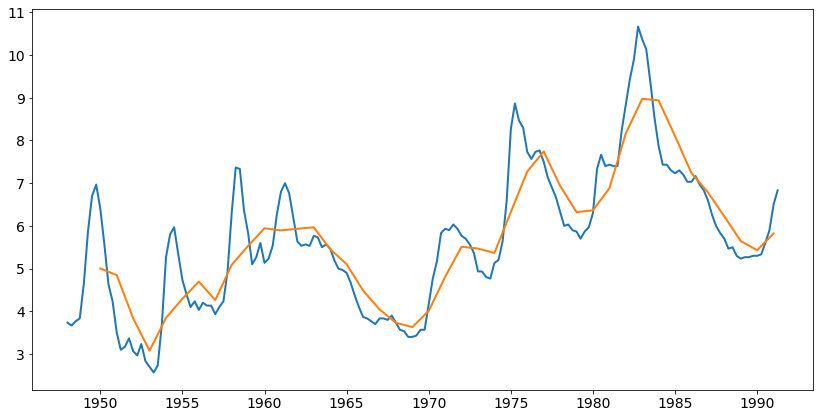

In [121]:
plt.figure(figsize=(14,7))

plt.plot(date_ticks_orig, unemp['unemployment_rate'].values,lw=2)
plt.plot(date_ticks_roll, yearly.values, lw=2)

plt.tick_params(labelsize=14)

### 4) Calculate the rolling median with `window=5` and `window=15`. Plot both together with the original data.

In [122]:
uroll_w5 = unemp['unemployment_rate'].rolling(window=5).median()
uroll_w15 = unemp['unemployment_rate'].rolling(window=15).median()

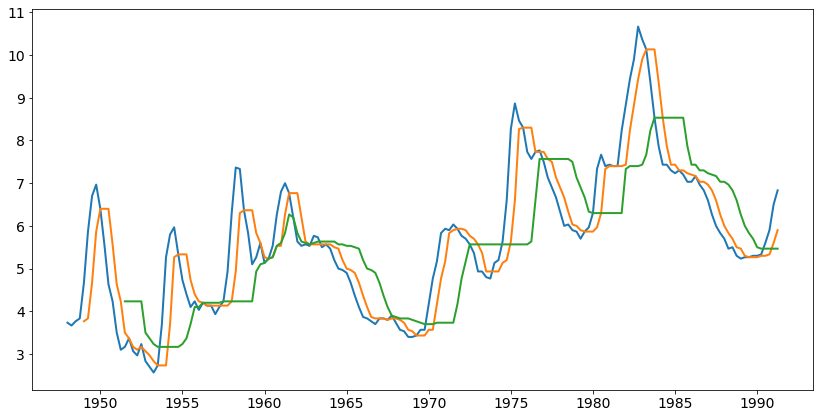

In [123]:
plt.figure(figsize=(14,7))

plt.plot(date_ticks_orig, unemp.unemployment_rate.values,lw=2)
plt.plot(date_ticks_orig, uroll_w5, lw=2)
plt.plot(date_ticks_orig, uroll_w15, lw=2)

plt.tick_params(labelsize=14)

### 5) Calculate and plot the expanding mean. Resample by quarter. Plot the rolling mean and the expanding mean together.

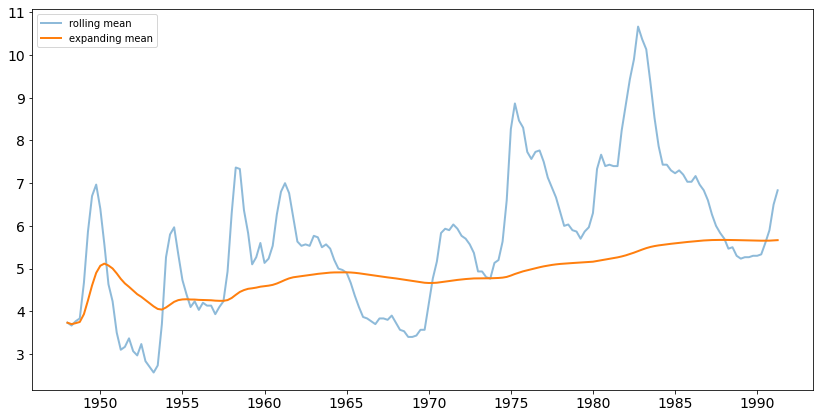

In [124]:
date_ticks = unemp.index.to_timestamp()

rolling_mean = unemp.unemployment_rate.resample('Q').sum().rolling(window=1, center=False).mean()
expanding_mean = unemp.unemployment_rate.resample('Q').sum().expanding().mean()

plt.figure(figsize=(14,7))

plt.plot(date_ticks, rolling_mean, alpha=.5, lw=2, label='rolling mean')
plt.plot(date_ticks, expanding_mean, alpha=1, lw=2, label='expanding mean')

plt.legend(loc='upper left')

plt.tick_params(labelsize=14)

### 6) Calculate and plot the exponentially weighted sum along with the rolling sum.

In [125]:
rolling_mean = unemp.unemployment_rate.resample('Q').sum().rolling(window=2, center=True).mean()
exp_weighted_mean = unemp.unemployment_rate.resample('Q').sum().ewm(span=10).mean()

<AxesSubplot:xlabel='date'>

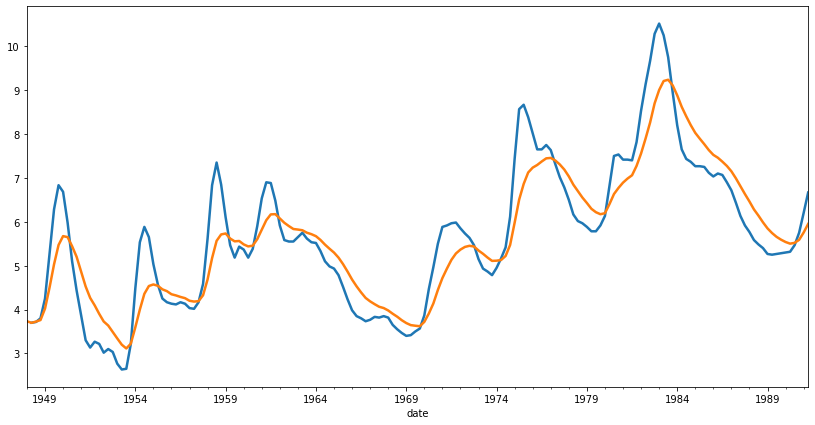

In [126]:
ax = rolling_mean.plot(lw=2.5, figsize=(14,7))
exp_weighted_mean.plot(ax=ax, lw=2.5)

### 7) Difference the unemployment rate and plot.
The `diff()` function calculates the difference of a DataFrame element compared with another element in the DataFrame.

In [127]:
# by default, it calculates by one row.
unemp['unemp_diff'] = unemp['unemployment_rate'].diff()
unemp[['unemployment_rate', 'unemp_diff']].head()


,unemployment_rate,unemp_diff
date,,
1948Q1,3.73,NaN
1948Q2,3.67,-0.07
1948Q3,3.77,0.10
1948Q4,3.83,0.07
1949Q1,4.67,0.83


In [128]:
# period of 2
unemp['unemp_diff2'] = unemp['unemployment_rate'].diff(periods=2)
unemp[['unemployment_rate', 'unemp_diff', 'unemp_diff2']].head()

,unemployment_rate,unemp_diff,unemp_diff2
date,,,
1948Q1,3.73,NaN,NaN
1948Q2,3.67,-0.07,NaN
1948Q3,3.77,0.10,0.03
1948Q4,3.83,0.07,0.17
1949Q1,4.67,0.83,0.90


<AxesSubplot:xlabel='date'>

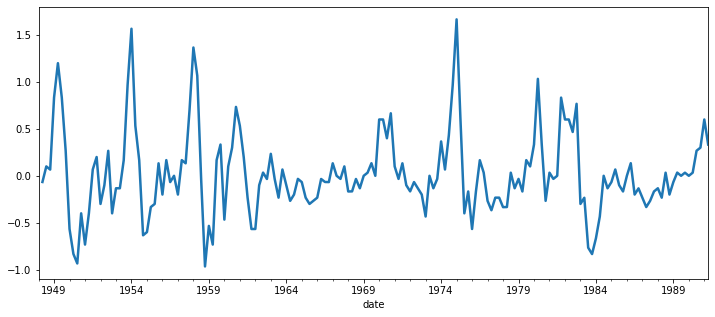

In [129]:
# plot the difference
unemp['unemp_diff'].plot(lw=2.5, figsize=(12,5))